In [1]:
import pandas as pd
import numpy as np
# import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import random
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)

import Functions as f

C:\Users\User\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
path = 'data_1.csv'
df = f.read_csv_file(path)
df.shape

(84, 62)

In [3]:
df = f.MissingValueHandling(df)

the columns that contain null values: ['thrustACCel_C', 'thrustACCel_T', 'max_stance_angles', 'age']
Missing values handled


In [4]:
df = f.Encoding(df)
    
# Check that the value transformed successfully 
print('Severity after Encoding:')
dict(df['severity'].value_counts())

Severity after Encoding:


{2: 33, 3: 21, 0: 16, 1: 14}

In [8]:
df = shuffle(df, random_state = random_seed)

columns_to_drop = ['patient_id', 'name', 'leg', 'severity']

X = df.drop(columns = columns_to_drop, axis = 1)  
y = df['severity']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train.shape

(67, 58)

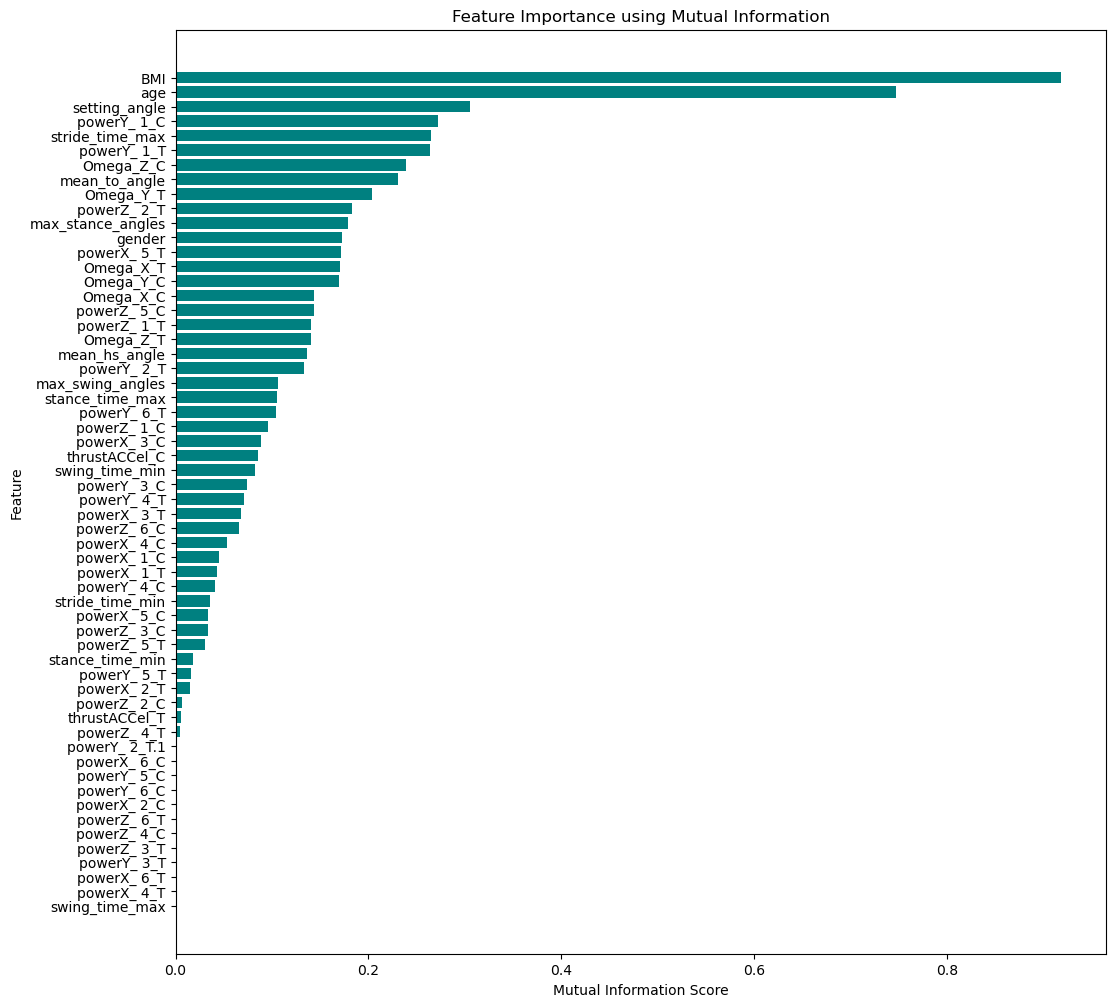

In [9]:
###################################################### Information Gain ######################################################
mi_scores = mutual_info_classif(X, y)
mi_scores_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
# Sort features by their mutual information scores
mi_scores_df = mi_scores_df.sort_values(by='MI Score', ascending=False)
# mi_scores_df

f.PlottingfeatureImportance(mi_scores_df['Feature'], mi_scores_df['MI Score'], 'Mutual Information Score', 'Feature', 'Feature Importance using Mutual Information')

In [10]:
X_train_filter, X_test_filter = f.DropAfterFeatureSelection(mi_scores_df, X_train, X_test)

the droped columns ['swing_time_max', 'powerX_ 4_T', 'powerX_ 6_T', 'powerY_ 3_T', 'powerZ_ 3_T', 'powerZ_ 6_T', 'powerX_ 2_C', 'powerX_ 6_C', 'powerY_ 2_T.1', 'powerY_ 5_C', 'powerY_ 6_C', 'powerZ_ 4_C']


In [11]:
X_train_filter, X_test_filter = f.ScalingData(X_train_filter, X_test_filter)

## After PCA

In [12]:
pca = PCA(n_components= 30)  # Example: Retain 10 principal components
X_train_pca = pca.fit_transform(X_train_filter)
X_test_pca = pca.transform(X_test_filter)

In [13]:
from imblearn.over_sampling  import RandomOverSampler
sampling_strategy = {
    0: 2500,
    1: 2500,
    2: 2500,
    3: 2500
    # Add more classes as needed
}

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize RandomOverSampler with the specified sampling strategy
smoteOver = RandomOverSampler(sampling_strategy = sampling_strategy)
# smoteOver = RandomOverSampler(sampling_strategy=1)
X_smoteOver_pca, y_smoteOver_pca = smoteOver.fit_resample(X_train_pca , y_train)
print(f' X_shape: {X_smoteOver_pca.shape} \n y_shape: {y_smoteOver_pca.shape}')

 X_shape: (10000, 30) 
 y_shape: (10000,)


In [14]:
results_smote_pca = []
models_sample = {
    "Random Forest": RandomForestClassifier(bootstrap = True, max_depth = None, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100, random_state = random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_sample.items():
    y_pred, train_accuracy, test_accuracy, f1, rmse = f.train_and_evaluate(model, model_name, X_smoteOver_pca, y_smoteOver_pca, X_test_pca, y_test)
    results_smote_pca.append((model_name, train_accuracy, test_accuracy, f1, rmse))
    # y_pred = model.predict(X_test)
    # f1 = f1_score(y_test, y_pred, average='weighted')
    # print(f"F1 Score ({model_name}): {f1:.4f}")
    # print('-' * 50)

results_smote_pca_df = pd.DataFrame(results_smote_pca, columns=['Model', 'train_acc', 'test_acc', 'f1_score', 'RMSE'])
results_smote_pca_df

,Model,train_acc,test_acc,f1_score,RMSE
0,Random Forest,100.00,52.94,0.513725,1.084652
1,Logistic Regression,100.00,35.29,0.321569,1.350381
2,KNN (k=7),100.00,64.71,0.654902,1.028992
3,XGBoost,100.00,52.94,0.509603,1.137593
4,linear SVM,100.00,35.29,0.326961,1.306094
5,Poly SVM,100.00,64.71,0.661848,0.840168
6,rbf SVM,100.00,58.82,0.509804,1.137593
7,Sigmoid SVM,84.47,29.41,0.278075,1.393261
8,Lasso Logistic Regression,100.00,35.29,0.326961,1.306094


In [ ]:
# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'bootstrap': [True, False]
# }

# # Initialize the Random Forest classifier
# rf = RandomForestClassifier()

# # Initialize the GridSearchCV object
# grid_search = GridSearchCV(estimator=rf, param_grid = param_grid,
#                            scoring='accuracy', cv = 5, n_jobs=-1, verbose=2)

# # Fit the grid search to the data
# grid_search.fit(X_smoteOver_pca, y_smoteOver_pca)

# # Get the best parameters and best score from the grid search
# best_params = grid_search.best_params_
# best_score = grid_search.best_score_

# print(f"Best Parameters: {best_params}")
# print(f"Best Cross-Validation Accuracy: {best_score}")

# # Train the Random Forest model with the best parameters
# best_rf = grid_search.best_estimator_

# # Predictions
# y_pred = best_rf.predict(X_test_pca)

# results = Evaluate(X_smoteOver_pca, y_smoteOver_pca, X_test_pca, y_test, y_pred)

## Before PCA

In [23]:
from imblearn.over_sampling  import RandomOverSampler
sampling_strategy = {
    0: 2500,
    1: 2500,
    2: 2500,
    3: 2500
    # Add more classes as needed
}

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

# Initialize RandomOverSampler with the specified sampling strategy
smoteOver = RandomOverSampler(sampling_strategy = sampling_strategy)
# smoteOver = RandomOverSampler(sampling_strategy=1)
X_smoteOver, y_smoteOver = smoteOver.fit_resample(X_train_filter , y_train)
print(f' X_shape: {X_smoteOver.shape} \n y_shape: {y_smoteOver.shape}')



 X_shape: (10000, 47) 
 y_shape: (10000,)


In [24]:
results_smote = []
models_sample = {
    "Random Forest": RandomForestClassifier(random_state=random_seed),
    "Logistic Regression": LogisticRegression(),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=5),
    "XGBoost": XGBClassifier(),
    "linear SVM": SVC(kernel='linear', random_state=random_seed),
    "Poly SVM": SVC(kernel='poly', random_state=random_seed),
    "rbf SVM": SVC(kernel='rbf', random_state=random_seed),
    "Sigmoid SVM": SVC(kernel= 'sigmoid', random_state=random_seed),
    "Lasso Logistic Regression": LogisticRegression(penalty='l1', solver='saga', multi_class='multinomial', max_iter=10000, random_state=random_seed)
}

# Train and evaluate each model
for model_name, model in models_sample.items():
    y_pred, train_accuracy, test_accuracy, f1, rmse = f.train_and_evaluate(model, model_name, X_smoteOver, y_smoteOver, X_test_filter, y_test)
    results_smote.append((model_name, train_accuracy, test_accuracy, f1, rmse))
    # y_pred = model.predict(X_test)
    # f1 = f1_score(y_test, y_pred, average='weighted')
    # print(f"F1 Score ({model_name}): {f1:.4f}")
    # print('-' * 50)

results_smote_df = pd.DataFrame(results_smote, columns=['Model', 'train_acc', 'test_acc', 'f1_score', 'RMSE'])
results_smote_df

,Model,train_acc,test_acc,f1_score,RMSE
0,Random Forest,100.00,76.47,0.747479,0.874475
1,Logistic Regression,100.00,70.59,0.717679,0.804400
2,KNN (k=7),100.00,58.82,0.625859,1.111438
3,XGBoost,100.00,94.12,0.944796,0.242536
4,linear SVM,100.00,70.59,0.721331,0.685994
5,Poly SVM,100.00,58.82,0.563783,1.057188
6,rbf SVM,100.00,82.35,0.820588,0.727607
7,Sigmoid SVM,84.35,52.94,0.517647,1.163160
8,Lasso Logistic Regression,100.00,82.35,0.823529,0.907485


## ANN

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical

# Load your dataset
# X, y = load_your_data()

# Handling class imbalance using SMOTE
smote = SMOTE()
X_res, y_res = smote.fit_resample(X, y)

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Example with RandomForest and GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

# Example with a simple neural network
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train_categorical, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model
scores = model.evaluate(X_test, y_test_categorical)
print("Neural Network Accuracy: %.2f%%" % (scores[1]*100))
